# Box 6.2: Worked example of multiple linear regression: Abundance of birds in forest patches
Loyn (1987) selected 56 forest patches in southeastern Victoria, Australia, and related the abundance of forest birds in each patch to six predictor variables: patch area (ha), distance to nearest patch (km), distance to nearest larger patch (km), grazing stock (1 to 5 indicating light to heavy), altitude (m) and years since isolation (years).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv('../../data/chpt6/loyn.csv')

In [3]:
df.head()

,ABUND,AREA,YR.ISOL,DIST,LDIST,GRAZE,ALT,L10DIST,L10LDIST,L10AREA,...,CL10AREA,CGRAZE,RESID1,PREDICT1,AREARESY,AREARESX,GRAZRESY,GRAZRESX,YRRESY,YRRESX
0,5.3,0.1,1968,39,39,2,160,1.591065,1.591065,-1.00000,...,-1.931935,-0.982143,-4.221798,9.521798,-16.489778,-1.642250,-1.317648,-1.741370,-4.324122,-1.385164
1,2.0,0.5,1920,234,234,5,60,2.369216,2.369216,-0.30103,...,-1.232965,2.017857,-1.033102,3.033102,-3.275036,-0.300116,-0.805155,-0.136680,-1.942302,-12.307939
2,1.5,0.5,1900,104,311,5,140,2.017033,2.492760,-0.30103,...,-1.232965,2.017857,-1.855642,3.355642,-6.688699,-0.646976,-1.424965,-0.258240,-3.808217,-26.432223
3,17.1,1.0,1966,66,66,3,160,1.819544,1.819544,0.00000,...,-0.931935,0.017857,2.278827,14.821173,-1.778062,-0.543074,2.458526,-0.107750,3.056407,10.526182
4,13.8,1.0,1918,246,246,5,140,2.390935,2.390935,0.00000,...,-0.931935,2.017857,7.139005,6.660995,4.706387,-0.325642,6.157437,0.588562,6.472277,-9.025571


In [4]:
# Due to an error in the dataset, the YR.ISOL is not the number of years since patch was isolated 
# but the year since the isolation. We therefore use CYR.ISOL which is the centered number of years since isolation
# and add the subtracted mean (33.25 from the book) to get the uncentered values
df = df[['ABUND','AREA','DIST', 'LDIST', 'GRAZE', 'ALT', 'CYR.ISOL']]
df.columns = ['ABUND','AREA','DIST', 'LDIST', 'GRAZE', 'ALT', 'YR_ISOL']
df['YR_ISOL'] = df['YR_ISOL'] + 33.25
df.head()

,ABUND,AREA,DIST,LDIST,GRAZE,ALT,YR_ISOL
0,5.3,0.1,39,39,2,160,51.5
1,2.0,0.5,234,234,5,60,3.5
2,1.5,0.5,104,311,5,140,-16.5
3,17.1,1.0,66,66,3,160,49.5
4,13.8,1.0,246,246,5,140,1.5


### Distribution

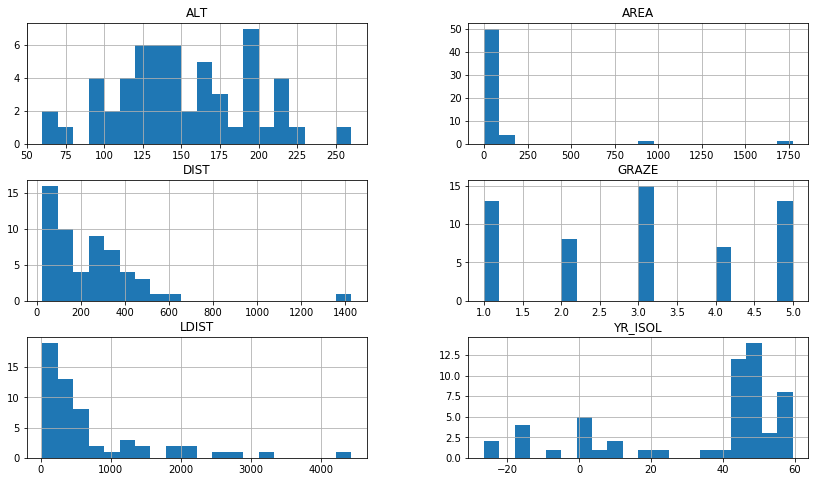

In [5]:
h = df[['AREA','DIST', 'LDIST', 'GRAZE', 'ALT', 'YR_ISOL']].hist(bins=20, figsize=(14,8))

Three of the predictor variables (patch area, distance to nearest patch or dist, distance to nearest larger patch or ldist) 

In [6]:
df['DIST_log'] = np.log10(df['DIST'])
df['LDIST_log'] = np.log10(df['LDIST'])
df['AREA_log'] = np.log10(df['AREA'])
del df['DIST']
del df['LDIST']
del df['AREA']

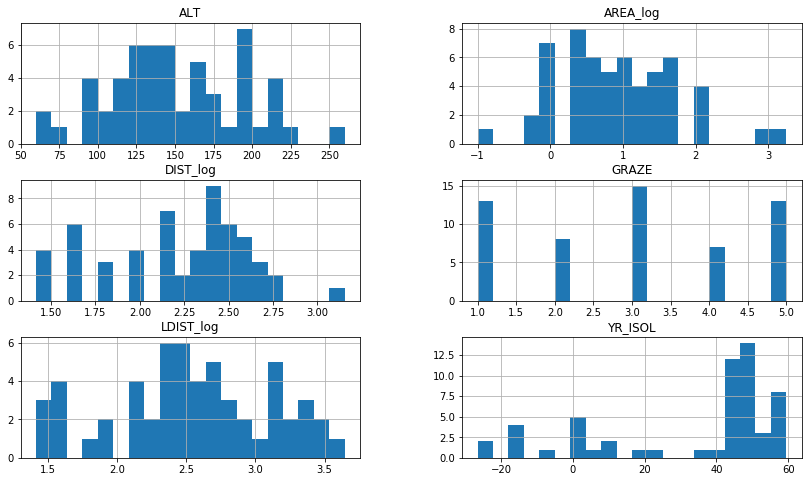

In [7]:
h = df[['AREA_log','DIST_log', 'LDIST_log', 'GRAZE', 'ALT', 'YR_ISOL']].hist(bins=20, figsize=(14,8))

### Correlation

In [8]:
df[['AREA_log','DIST_log', 'LDIST_log', 'GRAZE', 'ALT', 'YR_ISOL']].corr()

,AREA_log,DIST_log,LDIST_log,GRAZE,ALT,YR_ISOL
AREA_log,1.000000,0.302167,0.382480,-0.559089,0.275143,0.278415
DIST_log,0.302167,1.000000,0.603866,-0.142639,-0.219007,-0.019572
LDIST_log,0.382480,0.603866,1.000000,-0.033991,-0.274044,-0.161116
GRAZE,-0.559089,-0.142639,-0.033991,1.000000,-0.407167,-0.635567
ALT,0.275143,-0.219007,-0.274044,-0.407167,1.000000,0.232715
YR_ISOL,0.278415,-0.019572,-0.161116,-0.635567,0.232715,1.000000


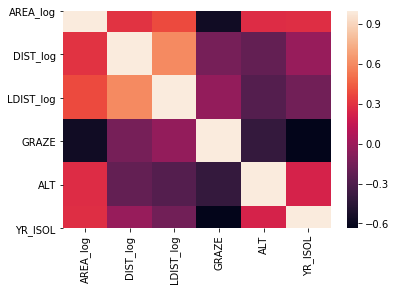

In [9]:
sns.heatmap(df[['AREA_log','DIST_log', 'LDIST_log', 'GRAZE', 'ALT', 'YR_ISOL']].corr())

A correlation matrix indicated some moderate correlations between predictors, especially between 
- $log_{10}(dist)$ and $log_{10}(ldist)$, $log_{10}(area)$ and graze, 
- graze and years.

# Multiple linear regression: Part 1
As for the data set from Paruelo & Lauenroth (1996), a multiple linear regres- sion model relating abundance of forest birds to all six predictor variables and their interactions would have 64 terms plus an intercept,and would be unwieldy to inter- pret. So an additive model was ﬁtted:  

$(bird abundance)_i = \beta_0 + \beta_1(log_{10}(area))_i + \beta_2(log_{10}(dist))_i + \beta_3(log_{10}(ldist))_i + \beta_4(grazing)_i + \beta_5(altitude)_i + \beta_6(years)_i + \epsilon_i$

In [10]:
ols_result = ols(formula='ABUND~AREA_log+DIST_log+LDIST_log+GRAZE+ALT+YR_ISOL', data=df).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  ABUND   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     17.75
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           8.44e-11
Time:                        19:46:26   Log-Likelihood:                -179.53
No. Observations:                  56   AIC:                             373.1
Df Residuals:                      49   BIC:                             387.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8765      9.373      1.694      0.0

### Model diagnostics

**Calculating Tolerance (inverso of Variance Inflaction Factor)**

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
variables = ols_result.model.exog
var_names = ols_result.model.exog_names
tollerance = [(var_names[i], 1/variance_inflation_factor(variables, i)) for i in range(variables.shape[1])]
tollerance

[('Intercept', 0.00828276737979916),
 ('AREA_log', 0.5231454328473059),
 ('DIST_log', 0.6043929883006927),
 ('LDIST_log', 0.49757455311871435),
 ('GRAZE', 0.396068816470563),
 ('ALT', 0.6812282270334273),
 ('YR_ISOL', 0.5540876183223902)]

tollarance values for all variables except intercet are above 0.1

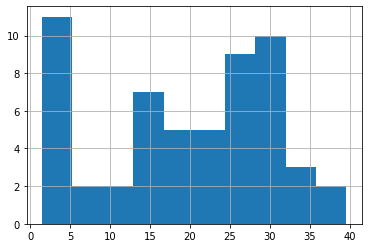

In [13]:
df['ABUND'].hist()

The response variable (bird abundance) is not skewed

Text(0, 0.5, 'Residuals')

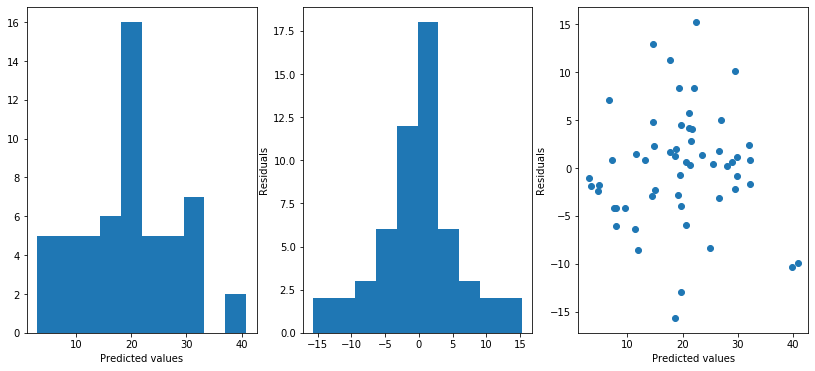

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(14,6))
ax[0].hist(ols_result.fittedvalues)
ax[0].set_xlabel('Predicted values')
ax[1].hist(ols_result.resid)
ax[1].set_ylabel('Residuals')
ax[2].scatter(ols_result.fittedvalues, ols_result.resid, marker='o')
ax[2].set_xlabel('Predicted values')
ax[2].set_ylabel('Residuals')

The boxplot of residuals was reasonably symmetrical and although there was some heterogeneity of spread of residuals when plotted against predicted values,

There was a signiﬁcant positive partial regression slope for bird **abundance** against $log_{10}(area)$. No other partial regression slopes were signiﬁcant.

The H0 that all partial regression slopes equal zero was also rejected.

# Multiple linear regression: Part 2
Now we will ﬁt a second model to investigate possible interactions between predictor variables. A model with six predictors plus interactions is unwieldy so we will simplify the model ﬁrst by omitting those predictors that contributed little to the original model ($log_{10}(dist)$, $log_{10}(ldist)$, **altitude**). The ﬁrst two were correlated with each other and with $log_{10}(area)$ anyway. Reﬁtting the additive model with these three predictors omitted changed the estimated regression slopes of the remaining terms only slightly, suggesting that any bias in the estimates of the remaining predictors from omitting other predictors is small. The final model is:  

$(bird abundance)_i = \beta_0 + \beta_1(log_{10}(area))_i + \beta_2(grazing)_i + \beta_3(years)_i + \beta_4(log_{10}(area)\cdot grazing)_i + \beta_5(log_{10}(area)\cdot years)_i + \beta_6(grazing\cdot years)_i + \beta_7(log_{10}(area) \cdot grazing \cdot years)_i + \epsilon_i$

In [15]:
ols_result_2 = ols(formula=
                   'ABUND~AREA_log+GRAZE+YR_ISOL+AREA_log*GRAZE+AREA_log*YR_ISOL+GRAZE*YR_ISOL+AREA_log*GRAZE*YR_ISOL', 
                  data=df).fit()

In [16]:
print(ols_result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  ABUND   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     21.31
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           9.76e-13
Time:                        19:46:27   Log-Likelihood:                -172.31
No. Observations:                  56   AIC:                             360.6
Df Residuals:                      48   BIC:                             376.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 47

In [17]:
variables = ols_result_2.model.exog
var_names = ols_result_2.model.exog_names
tollerance = [(var_names[i], 1/variance_inflation_factor(variables, i)) for i in range(variables.shape[1])]
tollerance

[('Intercept', 0.00544851659486123),
 ('AREA_log', 0.03530856637525848),
 ('GRAZE', 0.05933387908289989),
 ('YR_ISOL', 0.019993322528678803),
 ('AREA_log:GRAZE', 0.11854784376454364),
 ('AREA_log:YR_ISOL', 0.0282311540293757),
 ('GRAZE:YR_ISOL', 0.03625929095490299),
 ('AREA_log:GRAZE:YR_ISOL', 0.0749013663902649)]

Tollerance extremly smal, so we center the predictor variables

In [18]:
df_center = df.copy()
df_center = df_center.apply(lambda col: col-np.mean(col))
df_center['ABUND'] = df['ABUND']

In [19]:
ols_result_3 = ols(formula=
                   'ABUND~AREA_log+GRAZE+YR_ISOL+AREA_log*GRAZE+AREA_log*YR_ISOL+GRAZE*YR_ISOL+AREA_log*GRAZE*YR_ISOL', 
                  data=df_center).fit()
print(ols_result_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  ABUND   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     21.31
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           9.76e-13
Time:                        19:46:27   Log-Likelihood:                -172.31
No. Observations:                  56   AIC:                             360.6
Df Residuals:                      48   BIC:                             376.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 22

In [20]:
variables = ols_result_3.model.exog
var_names = ols_result_3.model.exog_names
tollerance = [(var_names[i], 1/variance_inflation_factor(variables, i)) for i in range(variables.shape[1])]
tollerance

[('Intercept', 0.432827261836776),
 ('AREA_log', 0.3732068601966364),
 ('GRAZE', 0.3857992014022803),
 ('YR_ISOL', 0.2796518676415165),
 ('AREA_log:GRAZE', 0.4500934303475065),
 ('AREA_log:YR_ISOL', 0.41105084308104556),
 ('GRAZE:YR_ISOL', 0.36195832043609477),
 ('AREA_log:GRAZE:YR_ISOL', 0.39730984850986806)]

The three-way interaction was not signiﬁcant so we will focus on the two-way interactions.

The $log_{10}(area)$ x **grazing** term indicates how much the effect of grazing on bird density depends on $log_{10}(area)$.
- This interaction is signiﬁcant, so we might want to look at simple effects of grazing on bird density for different values of $log_{10}(area)$. 
- We chose mean $log_{10}(area)$ (0.932) $\pm$ one standard deviation (0.120, 1.744).  
- Because the three-way interaction was not signiﬁcant, we simply set years since isolation to its mean value (33.25).  
- We could also just have ignored years since isolation and calculated simple slopes as for a two predictor model and got similar patterns.  
- The simple slopes of bird abundance against grazing for different $log_{10}(area)$ values and mean of years since isolation were as follows.

**To get the statistics for probing this interaction, we use the following procedure:**
1. Create a copy of the dataset used for fitting the model
2. Subtract the particular values from each "fixed" variable 
    - In our example we want to analyze the effect of grazing on bird abundance while fixing $log_{10}(area)$ and years sins isolation
    - we therefore subtract the fixed values 
        - **33.25** for YR_ISOL if we use uncentered values, otherwise the mean is already subtracted
        - mean of log-area $\pm$ **0.12** / **1.744** for log_area) from the initial values
3. Fit the same model whit the new dataset
4. The partial slope of abundance on grazing and all related statistics can be extracted from the grazing row
    

In [21]:
# Example for centerd data. We dont have to subtract the mean 
df2 = df_center.copy()
df2.loc[:,'AREA_log'] = df2['AREA_log'] + np.std(df2['AREA_log'])

In [22]:
# # Example for uncentered data
# df2 = df.copy()
# df2.loc[:,'YR_ISOL'] = df2['YR_ISOL'] - np.mean(df2['YR_ISOL'])
# df2.loc[:,'AREA_log'] = df2['AREA_log'] - (np.mean(df2['AREA_log']) - np.std(df2['AREA_log']))

In [23]:
ols_result_4 = ols(formula=
                   'ABUND~AREA_log+GRAZE+YR_ISOL+AREA_log*GRAZE+AREA_log*YR_ISOL+GRAZE*YR_ISOL+AREA_log*GRAZE*YR_ISOL', 
#                    'ABUND~GRAZE+AREA_log+GRAZE*AREA_log',
                  data=df2).fit()
print(ols_result_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  ABUND   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     21.31
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           9.76e-13
Time:                        19:46:27   Log-Likelihood:                -172.31
No. Observations:                  56   AIC:                             360.6
Df Residuals:                      48   BIC:                             376.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 16